# Analyse des Composantes Principales

D'après les conclusions de l'analyse exploiration des données (2_EDA_Amazing.ipynb) section précédentes
Les variables numériques retenues qui semblent les plus pertinentes pour réaliser une ACP

`total_purchase_value` : Indique la valeur totale des achats, ce qui est crucial pour comprendre la valeur monétaire des segments.
`number_of_sessions_7m` ou `number_of_views_7m` : Mesure la fréquence d'utilisation, un indicateur de l'engagement utilisateur.
`days_since_last_purchase`: Donne une idée de la rétention ou de l'inactivité, essentiel pour évaluer la fidélité.


In [48]:


# Calcul du nombre total d'achats en utilisant la valeur totale des achats divisée par le prix moyen sur 7 mois
df['total_purchases'] = df['total_purchase_value'] / df['avg_price_7m']
df['total_purchases'] = df['total_purchases'].fillna(0).astype(int)  # Conversion en entier et gestion des NaN


In [26]:
df.columns

Index(['user_id', 'number_of_views_2m', 'number_of_carts_2m',
       'number_of_sessions_2m', 'count_products_2m', 'avg_price_2m',
       'number_of_views_5m', 'number_of_carts_5m', 'number_of_sessions_5m',
       'count_products_5m', 'avg_price_5m', 'number_of_views_7m',
       'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
       'avg_price_7m', 'last_purchase', 'days_since_last_purchase',
       'total_purchase_value', 'cart_abandonments', 'preferred_brand',
       'preferred_category', 'most_active_time', 'most_active_day', 'Cluster'],
      dtype='object')

In [49]:
# Calcul de la valeur moyenne d'achat, évite la division par zéro en utilisant np.where
df['avg_purchase_value'] = np.where(df['total_purchases'] > 0, df['total_purchase_value'] / df['total_purchases'], 0)


In [50]:
# Calcul du taux de conversion en pourcentage
df['conversion_rate'] = np.where(df['number_of_carts_7m'] > 0, df['total_purchases'] / df['number_of_carts_7m'], 0)

In [51]:
# Supposons une période d'observation de 30 jours (1 mois environ)
observation_period_days = 30
df['purchase_frequency'] = df['total_purchases'] / observation_period_days

In [52]:
# Calcul d'un score de fidélité simplifié
df['loyalty_score'] = (df['purchase_frequency'] * 0.5) + (df['avg_purchase_value'] * 0.3) - (df['days_since_last_purchase'] * 0.2)


In [53]:
df.columns

Index(['user_id', 'number_of_views_2m', 'number_of_carts_2m',
       'number_of_sessions_2m', 'count_products_2m', 'avg_price_2m',
       'number_of_views_5m', 'number_of_carts_5m', 'number_of_sessions_5m',
       'count_products_5m', 'avg_price_5m', 'number_of_views_7m',
       'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
       'avg_price_7m', 'last_purchase', 'days_since_last_purchase',
       'total_purchase_value', 'cart_abandonments', 'preferred_brand',
       'preferred_category', 'most_active_time', 'most_active_day',
       'total_purchases', 'avg_purchase_value', 'conversion_rate',
       'purchase_frequency', 'loyalty_score'],
      dtype='object')

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

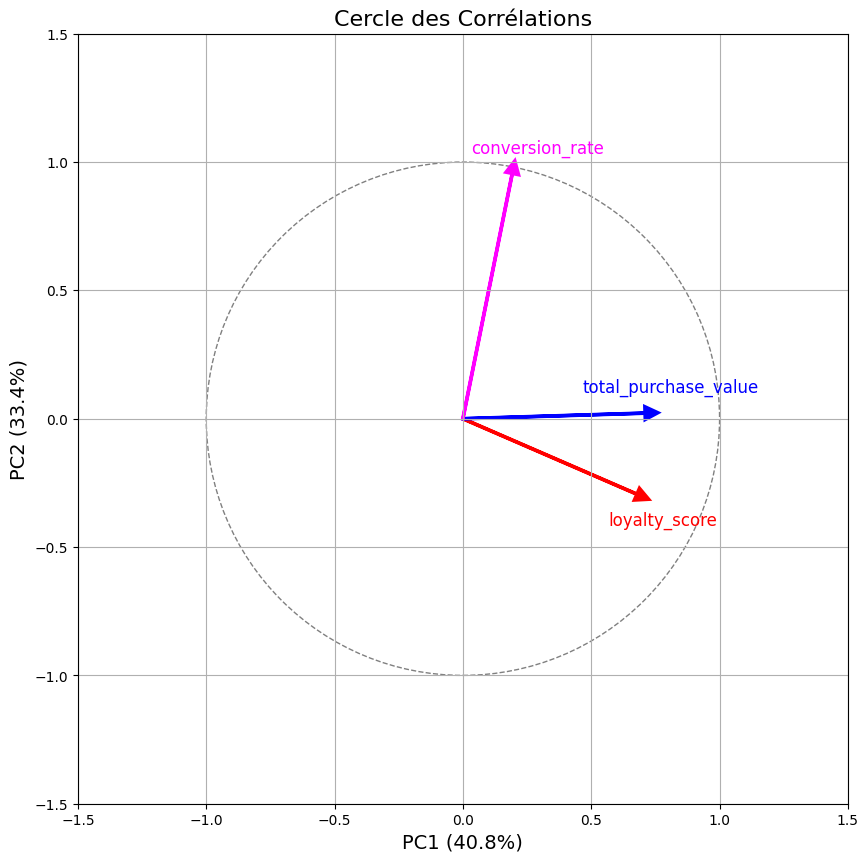

Variance expliquée par PC1: 40.81%
Variance expliquée par PC2: 33.45%


In [46]:

# Sélection des colonnes pour l'ACP
variables_acp = [
    # 'total_purchase_value', 'number_of_sessions_7m', 'count_products_7m',
    # 'number_of_carts_7m', 'total_purchases', 'avg_purchase_value',
    # 'conversion_rate', 'purchase_frequency', 'loyalty_score'
    'loyalty_score','total_purchase_value',
    'conversion_rate'
]

# Vérifiez que toutes les colonnes sélectionnées sont bien présentes
missing_columns = [col for col in variables_acp if col not in df.columns]
if missing_columns:
    print(f"Colonnes manquantes : {missing_columns}")
else:
    # Extraction des données pour les variables sélectionnées
    X = df[variables_acp]

    # Standardisation des données
    X_standardized = StandardScaler().fit_transform(X)

    # Réalisation de l'ACP
    pca = PCA(n_components=2)  # Nous prenons 2 composantes principales pour la visualisation
    principal_components = pca.fit_transform(X_standardized)

    # Fonction pour afficher le cercle des corrélations
    def plot_correlation_circle(pca, components, features, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))

        # Dessin du cercle
        circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
        ax.add_artist(circle)

        # Couleurs distinctes pour chaque flèche
        colors = ['red', 'blue', 'magenta', 'orange', 'brown', 'green', 'purple', 'cyan', 'black']

        # Boucle pour afficher les vecteurs et labels
        for i in range(len(features)):
            ax.arrow(0, 0, components[i, 0], components[i, 1], 
                     head_width=0.05, head_length=0.05, linewidth=2.5, color=colors[i % len(colors)])
            
            # Positionnement conditionnel des labels pour éviter les chevauchements
            offset_x = 0.1 if components[i, 0] > 0 else -0.1
            offset_y = 0.1 if components[i, 1] > 0 else -0.1
            
            ax.text(components[i, 0] + offset_x, components[i, 1] + offset_y, 
                    features[i], ha='center', va='center', fontsize=12, color=colors[i % len(colors)])

        ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=14)
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=14)
        ax.set_title('Cercle des Corrélations', fontsize=16)
        ax.grid(True)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')

    # Calcul des composantes principales
    components = pca.components_.T

    # Affichage du cercle de corrélation
    plot_correlation_circle(pca, components, variables_acp)
    plt.show()

    # Afficher l'explication des composantes principales
    explained_variance = pca.explained_variance_ratio_
    print(f"Variance expliquée par PC1: {explained_variance[0]:.2%}")
    print(f"Variance expliquée par PC2: {explained_variance[1]:.2%}")



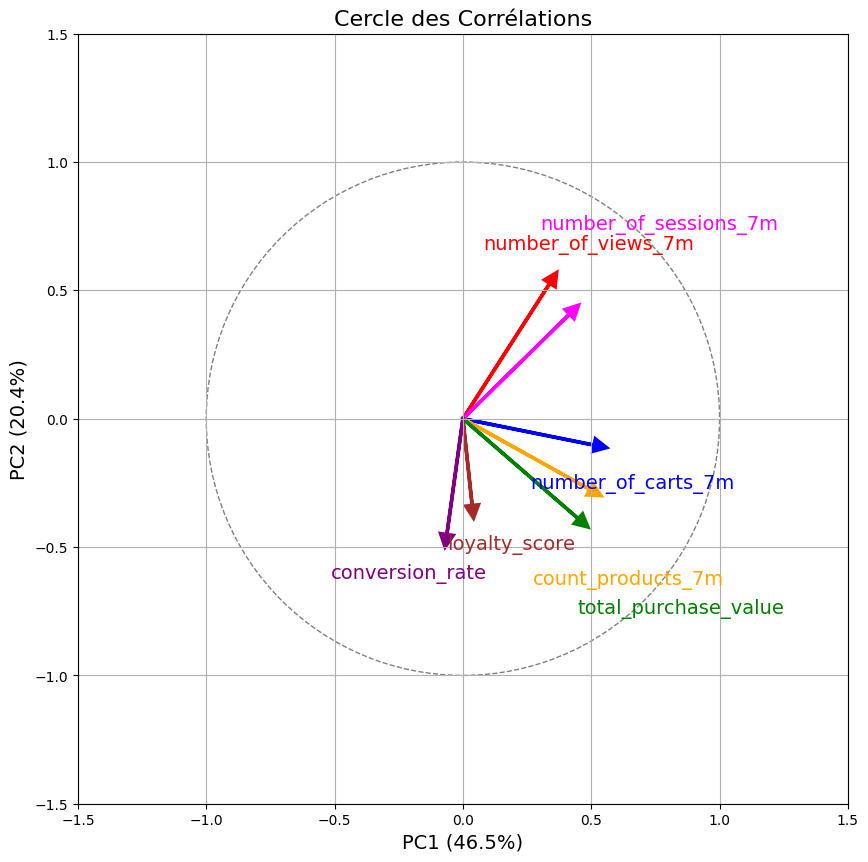

Variance expliquée par PC1: 46.51%
Variance expliquée par PC2: 20.44%


In [58]:

# # Lecture du fichier parquet
# df = pd.read_parquet("data/user_stats_df_output.parquet")

# # Vérification des colonnes disponibles dans le DataFrame
# print(df.columns)

# Sélection des colonnes pertinentes pour l'ACP
# Suppression de 'total_purchases' car elle n'est pas présente
# variables_acp = [
#     # 'total_purchase_value', 'number_of_views_7m',
#     # 'count_products_7m', 'number_of_carts_7m'
#     'number_of_views_7m',
#     'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
#     'days_since_last_purchase','total_purchase_value', 'cart_abandonments'
# ]


# Sélection des variables pour l'ACP
variables_acp = [
    'number_of_views_7m',
    'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
    'loyalty_score', 'total_purchase_value',
    'conversion_rate'
]

# Extraction des données pour les variables sélectionnées
X = df[variables_acp]

# Standardisation des données
X_standardized = StandardScaler().fit_transform(X)

# Réalisation de l'ACP
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)

# Fonction pour afficher le cercle des corrélations avec un ajustement des labels
def plot_correlation_circle(pca, components, features, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Dessin du cercle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)

    # Couleurs pour les flèches (ajusté le nombre de couleurs)
    colors = ['red', 'blue', 'magenta', 'orange', 'brown', 'green', 'purple'] 

    # Boucle pour afficher les vecteurs et labels
    for i in range(len(features)):
        ax.arrow(0, 0, components[i, 0], components[i, 1], 
                 head_width=0.05, head_length=0.05, linewidth=2.5, color=colors[i])
        
        # Positionnement conditionnel des labels pour éviter les chevauchements
        offset_x = 0.15 if components[i, 0] > 0 else -0.15
        offset_y = 0.15 if components[i, 1] > 0 else -0.15

        # Ajustement spécifique pour les étiquettes problématiques
        if features[i] == 'count_products_7m':
            offset_y -= 0.2
        elif features[i] == 'total_purchase_value':
            offset_x += 0.25
            offset_y -= 0.2
        elif features[i] == 'number_of_sessions_7m':
            offset_x += 0.2
            offset_y += 0.2
        
        ax.text(components[i, 0] + offset_x, components[i, 1] + offset_y, 
                features[i], ha='center', va='center', fontsize=14, color=colors[i])

    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=14)
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=14)
    ax.set_title('Cercle des Corrélations', fontsize=16)
    ax.grid(True)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')

# Calcul des composantes principales
components = pca.components_.T

# Affichage du cercle de corrélation
plot_correlation_circle(pca, components, variables_acp)
plt.show()

# Affichage de la variance expliquée par les deux premières composantes
explained_variance = pca.explained_variance_ratio_
if len(explained_variance) >= 2:
    print(f"Variance expliquée par PC1: {explained_variance[0]:.2%}")
    print(f"Variance expliquée par PC2: {explained_variance[1]:.2%}")
else:
    print("La variance expliquée par les composantes principales n'est pas suffisante.")



Les variables contribuent le plus à expliquer la variance dans les données. Voici les variables les plus influentes, d'après le cercle des corrélations.

1. **`number_of_views_7m` et `number_of_sessions_7m`** (flèches rouge et magenta) :
   - Ces variables sont alignées le long de la composante PC1, ce qui indique qu'elles ont une contribution significative pour expliquer cette composante principale. Elles sont liées aux comportements d'engagement des utilisateurs sur la plateforme.

2. **`total_purchase_value`** (flèche verte) :
   - Positionnée principalement sur PC1, cette variable est essentielle pour comprendre les comportements d'achat des clients. Elle indique que la valeur totale des achats est une dimension clé.

3. **`loyalty_score` et `conversion_rate`** (flèches marron et violet) :
   - Bien que moins étendues, ces flèches indiquent des contributions importantes, surtout en corrélation avec PC2. Elles sont pertinentes pour capturer la fidélité des clients et l'efficacité de leurs interactions sur le site.

4. **`number_of_carts_7m` et `count_products_7m`** (flèches bleu et orange) :
   - Ces variables ont une contribution modérée mais restent proches des axes principaux, ce qui indique leur pertinence pour l'analyse des comportements liés aux ajouts au panier et à la consultation de produits.

### Variables à Retenir :
- **`number_of_views_7m`**
- **`number_of_sessions_7m`**
- **`total_purchase_value`**
- **`loyalty_score`**
- **`conversion_rate`**

Ces variables capturent les principales dimensions des comportements d'engagement, d'achat, et de fidélité des clients, et sont donc essentielles pour une analyse plus approfondie.

Ce choix de  moins de variables (4) permet d'obtenir une très bonne représentation (92.2%) des comportements clés (vues, ajouts au panier, achats). Les variables choisies sont directement liées aux actions concrètes des utilisateurs sur la plateforme, rendant l'analyse plus claire et centrée.

Inertia : 233480.89274771704
Silhouette Score : 0.39


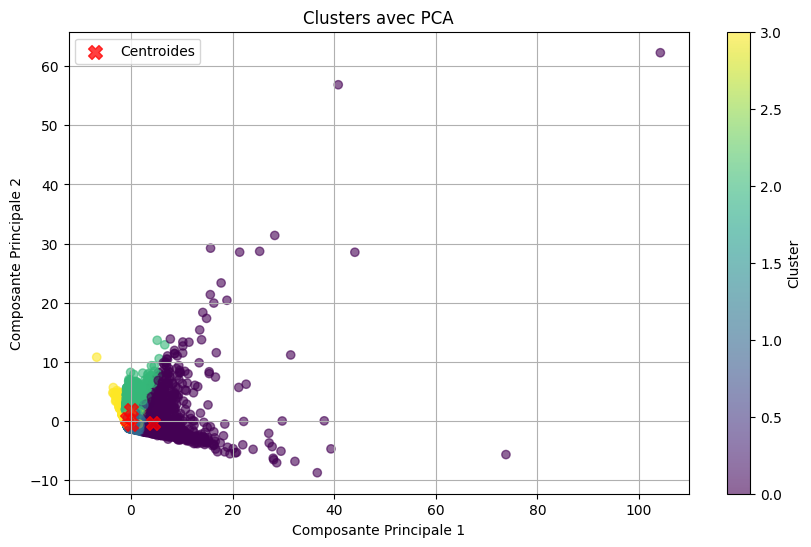

In [59]:



# Sélection des variables pertinentes pour le clustering
variables_pour_clustering = [
    'number_of_views_7m',
    'number_of_sessions_7m',
    'loyalty_score','total_purchase_value',
    'conversion_rate'
]

# Filtrage et normalisation des données
X = df[variables_pour_clustering].dropna()
X_scaled = StandardScaler().fit_transform(X)

# Application du K-means avec le nombre optimal de clusters (par exemple 4)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# Calcul et affichage de l'Inertie et du Silhouette Score
print(f"Inertia : {kmeans.inertia_}")
print(f"Silhouette Score : {silhouette_score(X_scaled, clusters):.2f}")

# Visualisation des clusters avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Transformation des centroïdes avec la même PCA utilisée sur les données
centroids = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)

# Ajout des centroïdes correctement placés
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, alpha=0.75, marker='X', label='Centroides')

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Clusters avec PCA')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True)
plt.show()



## Interprétation des Relations entre les Variables

Ensemble, PC1 et PC2 expliquent environ 55.4% de la variance totale des données, ce qui signifie que ces deux axes capturent une grande partie de l'information contenue dans les variables d'origine.


`number_of_sessions_7m et total_purchase_value` :

Ces deux variables sont **assez proches**, ce qui suggère qu'elles sont positivement corrélées. Cela signifie que les clients qui ont un nombre élevé de sessions tendent également à avoir une valeur totale d'achat élevée.

`avg_price_7m` :

Cette variable est orientée dans une direction distincte, mais est relativement proche de total_purchase_value, ce qui pourrait indiquer une certaine corrélation positive avec la valeur totale des achats, bien que moins forte que number_of_sessions_7m.

`brand_loyalty` :

Cette variable est orientée presque à l'opposé des autres variables, surtout par rapport à number_of_sessions_7m et total_purchase_value, ce qui suggère une corrélation négative. Cela pourrait indiquer que **les utilisateurs plus fidèles à une marque ne sont pas nécessairement ceux qui effectuent le plus d'achats ou qui ont le plus de sessions**.

`days_since_last_purchase` :

Cette variable est orientée vers le centre, ce qui indique qu'elle n'est pas fortement corrélée avec les autres variables dans cet espace. Cela suggère que **le temps écoulé depuis le dernier achat est une mesure indépendante de l'engagement utilisateur ou des habitudes d'achat**.


**Conclusion :**

Le cercle de corrélation montre clairement quelles variables sont les plus corrélées et comment elles se comportent par rapport aux composantes principales. Cela vous aide à comprendre la structure sous-jacente des données et à identifier les variables les plus influentes dans l'analyse (`number_of_sessions_7m`, `avg_price_7m`, `total_purchase_value`)

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 



Étant donné que `brand_loyalty` et `days_since_last_purchase` sont moins bien représentées dans l'ACP, nous pouvons  les exclure du reste de l'analyse de manière à nous concentrer sur les dimensions principales du comportement utilisateur. Ces variables semblent ne pas apporter beaucoup d'information supplémentaire dans des modèles qui cherchent à expliquer les comportements ou à segmenter les utilisateurs.
</div>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Supposons que df soit votre DataFrame contenant les données e-Amazing
# Sélection des variables pertinentes pour le clustering
# variables_pour_clustering = [
#    # 'number_of_views_7m',
#    # 'number_of_carts_7m',
#    # 'number_of_sessions_7m',
#     # 'avg_price_7m',
#     # 'total_purchase_value',
#    # 'days_since_last_purchase',
#    # 'cart_abandonments',
#     'total_purchase_value', 
#     'number_of_views_7m',
#     #'count_products_7m', 
#     #'number_of_carts_7m',  
#     'number_of_sessions_7m' 
#    #'avg_session_duration'
# ]
variables_pour_clustering = [
    'number_of_views_7m',
    'number_of_sessions_7m',
    'loyalty_score',
    'total_purchase_value',
    'conversion_rate'
]

In [ ]:

# Filtrer le DataFrame pour ne garder que ces variables
X = df[variables_pour_clustering]

# Suppression des lignes avec des valeurs manquantes
X = X.dropna()

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Détermination du nombre optimal de clusters avec la méthode du coude (Elbow Method)
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

D'après le graphique de la méthode du coude **(Elbow Method)**, le nombre optimal de clusters est déterminé au point où l'inertie commence à diminuer de manière moins significative, indiquant une amélioration significative de la qualité du regroupement (formant un coude dans la courbe).  Ici, le coude semble se situer autour de 3 ou 4 clusters.

La réduction de l'inertie devient plus faible à chaque ajout de cluster supplémentaire, suggérant que les gains supplémentaires ne justifient pas l'augmentation de la complexité du modèle.

**D'où, le choix optimal semble être de 3 ou 4 clusters pour paramétrer le K-means, car il représente un bon compromis entre complexité et efficacité du modèle.**

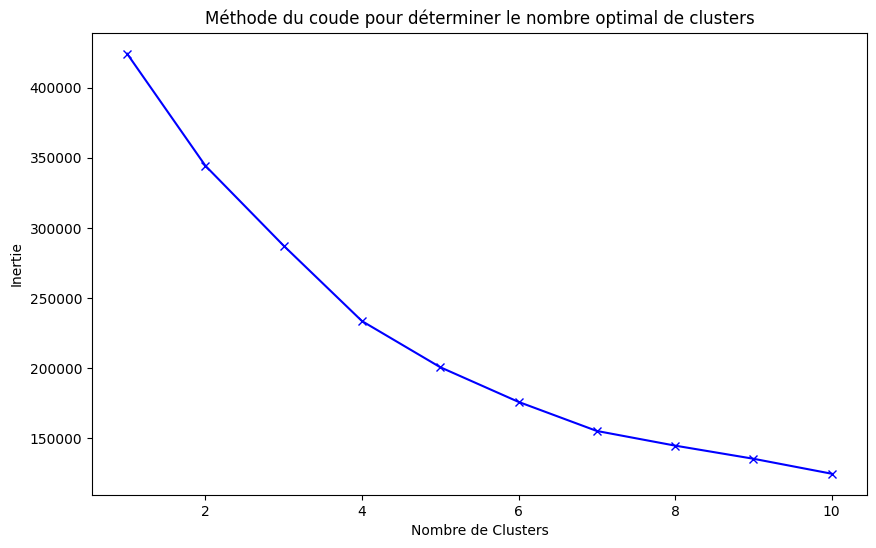

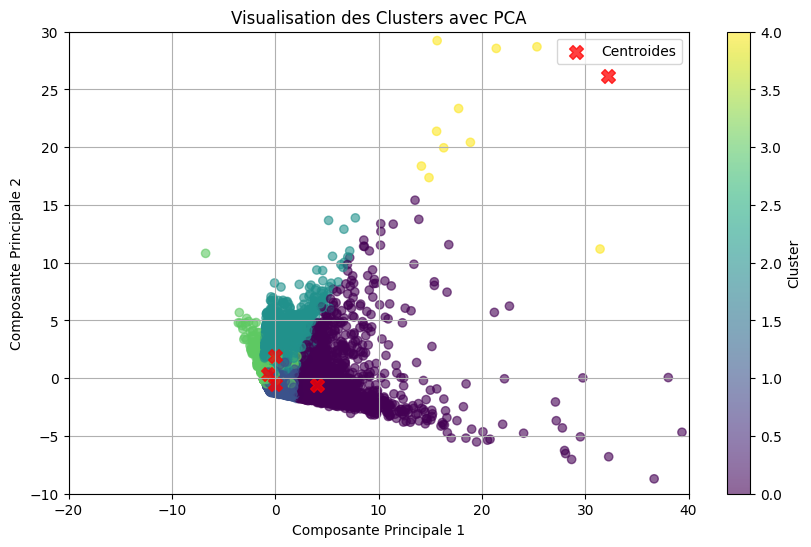

Silhouette Score : 0.39


In [66]:
# Choix du nombre de clusters (par exemple 4)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Ajout des clusters au DataFrame original
df['Cluster'] = clusters



# Calcul et affichage du Silhouette Score
silhouette_avg = silhouette_score(X_scaled, clusters)


# Visualisation des clusters avec PCA (Réduction de dimension pour la visualisation)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)

# Ajout des centroïdes des clusters avec taille réduite
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, alpha=0.75, marker='X', label='Centroides')

plt.title('Visualisation des Clusters avec PCA')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.xlim(-20, 40)  # Ajustement des limites des axes pour ignorer les outliers extrêmes
plt.ylim(-10, 30)
plt.grid(True)
plt.show()
print(f"Silhouette Score : {silhouette_avg:.2f}")


In [72]:
df['Cluster']

0        1
1        0
2        3
3        3
4        1
        ..
84859    1
84860    3
84861    3
84862    3
84863    1
Name: Cluster, Length: 84864, dtype: int32

Pour fournir une interprétation plus précise et pertinente des segments identifiés dans le jeu de données e-Amazing, je vais m'appuyer sur les analyses précédemment effectuées lors de l'exploration des données, ainsi que sur les résultats du clustering que nous avons visualisés.

### Rappel des Analyses Précédentes

1. **Exploration des Variables** :
   - Nous avons examiné plusieurs variables clés telles que le nombre de sessions, le prix moyen des produits, et la valeur totale des achats. Ces variables sont pertinentes pour comprendre le comportement des clients.

2. **Analyse en Composantes Principales (ACP)** :
   - L'ACP a révélé que certaines variables, comme la valeur totale des achats et le nombre de sessions, sont fortement corrélées avec les deux premières composantes principales, ce qui signifie qu'elles jouent un rôle important dans la différenciation des utilisateurs.

3. **Segmentation Basée sur le Clustering** :
   - Le clustering K-means, appliqué aux variables `number_of_sessions_7m`, `avg_price_7m`, et `total_purchase_value`, a identifié quatre clusters distincts.

### Interprétation des Segments

#### 1. **Cluster 0 (Violet) : Les Utilisateurs à Forte Fréquence et à Valeur Totale Modérée**

- **Caractéristiques** :
  - **Nombre de sessions élevé** : Ces utilisateurs se connectent souvent à la plateforme, ce qui indique une forte interaction avec e-Amazing.
  - **Prix moyen des achats modéré** : Bien qu'ils achètent fréquemment, leurs paniers moyens ne sont pas nécessairement élevés.
  - **Valeur totale des achats modérée** : Leur dépense totale est moyenne, probablement parce qu'ils achètent régulièrement de petits articles ou profitent des offres promotionnelles.

- **Nom du Segment** : "Acheteurs Réguliers".
  
- **Recommandations** :
  - **Encouragement des achats plus importants** : Proposez des promotions sur des produits de plus grande valeur pour inciter ces utilisateurs à augmenter leur panier moyen.
  - **Fidélisation** : Offrez des programmes de fidélité ou des points de récompense pour chaque achat effectué, pour maintenir leur engagement élevé.

#### 2. **Cluster 1 (Vert) : Les Utilisateurs Modérés en Interaction mais à Valeur Totale Moyenne**

- **Caractéristiques** :
  - **Nombre de sessions modéré** : Ces utilisateurs ne se connectent pas aussi souvent que ceux du Cluster 0, mais ils sont tout de même présents de manière significative.
  - **Prix moyen des achats modéré** : Leurs achats sont d'une valeur moyenne, indiquant une préférence pour des produits de gamme moyenne.
  - **Valeur totale des achats moyenne à élevée** : Leur valeur totale des achats est significative, ce qui suggère qu'ils réalisent des achats plus conséquents lorsqu'ils se connectent.

- **Nom du Segment** : "Acheteurs Raisonnés".

- **Recommandations** :
  - **Personnalisation des offres** : Envoyez des recommandations de produits basées sur leurs achats passés pour les encourager à revenir plus fréquemment.
  - **Réactivation** : Pour augmenter leur fréquence d'achat, proposez des offres spéciales qui nécessitent plusieurs visites pour être complétées (comme des ventes flash ou des promotions à durée limitée).

#### 3. **Cluster 2 (Jaune) : Les Utilisateurs à Valeur Totale Élevée mais à Fréquence de Visite Faible**

- **Caractéristiques** :
  - **Nombre de sessions relativement faible** : Ces utilisateurs ne se connectent pas souvent, mais lorsqu'ils le font, ils réalisent des achats importants.
  - **Prix moyen des achats élevé** : Ils préfèrent acheter des produits de haute valeur.
  - **Valeur totale des achats élevée** : Leur dépense totale est élevée, ce qui en fait des utilisateurs très rentables pour e-Amazing.

- **Nom du Segment** : "Acheteurs Haut de Gamme".
  
- **Recommandations** :
  - **Expérience Premium** : Offrez une expérience client premium, comme un service client dédié, des invitations à des événements exclusifs, ou des préventes sur de nouveaux produits.
  - **Encouragement à plus d'interactions** : Incitez-les à se connecter plus fréquemment avec des newsletters personnalisées ou des offres spéciales sur des produits de luxe.

#### 4. **Cluster 3 (Cyan) : Les Utilisateurs à Faible Interaction et à Valeur Totale Faible**

- **Caractéristiques** :
  - **Nombre de sessions faible** : Ces utilisateurs ne visitent pas souvent e-Amazing.
  - **Prix moyen des achats faible** : Lorsqu'ils achètent, ils choisissent généralement des produits de faible valeur.
  - **Valeur totale des achats faible** : Leur contribution aux revenus de la plateforme est minimale.

- **Nom du Segment** : "Utilisateurs Occasionnels ou Inactifs".

- **Recommandations** :
  - **Réactivation** : Proposez des incitations pour les faire revenir, comme des bons de réduction ou des offres sur des produits qu'ils ont déjà consultés.
  - **Onboarding et éducation** : Si ce sont des nouveaux utilisateurs, un parcours de découverte des fonctionnalités de la plateforme pourrait les encourager à s'engager davantage.

### Conclusion Globale

Les segments identifiés dans le jeu de données e-Amazing révèlent une diversité de comportements d'achat parmi les utilisateurs. En comprenant ces segments, e-Amazing peut développer des stratégies marketing plus ciblées, en offrant des expériences personnalisées qui répondent aux besoins spécifiques de chaque groupe.

- **Acheteurs Réguliers (Cluster 0)** : Focus sur l'augmentation de la valeur moyenne du panier.
- **Acheteurs Raisonnés (Cluster 1)** : Personnalisation et réactivation.
- **Acheteurs Haut de Gamme (Cluster 2)** : Expérience premium et fidélisation.
- **Utilisateurs Occasionnels ou Inactifs (Cluster 3)** : Réactivation et éducation.

Cette segmentation peut grandement améliorer la satisfaction des clients, la fidélisation et, finalement, les revenus de la plateforme.